<h1>Analysing Molecular Dynamic simulation Data</h1>

After producing our packed topology files using CHARM and Packmol, this will produce a .pdb (topology file)
The topology file will have been ran through OpenMM, which will produce a trajectory file .dcd (traj)

Using a vareity of molecular dynamic analysis packages such as MDanalysis and cpptraj, we will conduct a range of analyses on the molecular dynamics data, which have been produced

Throughout the notebook a range of figures will be shown which have been taken from VMD, for the project. Although this notebook aims to investigate the formation of specifically YAP condensates, Any element (code blocks), can be simply edited to be reused for other biological condensate system

<b>Contents</b>

<ol>
    <li> RMSD </li>
    <li> Rg analysis </li>
    <li> Condensate Analysis </li>
    <li> Terminal and Core analysis </li>
    <li>DSSP secondary structure analysis</li>
</ol>

<h2>Importing data</h2>

In [33]:
#This will initialise the packages for this notebook
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
#Use this codeblock to initialise your trajectory and topology files

Topology_file = './100_2000x2000x2000.pdb' #PUT YOUR TOPOLOGY FILE HERE
Trajectory_file = '/Users/hughie_d/Downloads/hughie_do_5_openmm/Residue contacts/Analysis/experiment_3/clean_trajectory.dcd' #PUT YOUR TRAJECTORY FILE HERE



Number_of_proteins = 100

u = mda.Universe(Topology_file, Trajectory_file)

<h2>1. RMSD data</h2>

The codeblocks below are used to work process the RMSD data in reference to the first frame of the simulation


In [35]:
from MDAnalysis.analysis import rms

r_calc = rms.RMSD(u, u,select = 'name CA and resid 2 to 151', ref_frame=0) # change the <select=> parameter to the atoms you want to use


r_calc.run()

In [ ]:
ps = 217/584 #Obatining the timestep in nanoseconds for the experiment

#Change this based on your overall system (total MD sim runtime / number of frames)

print(ps)

0.3715753424657534


In [ ]:
df = pd.DataFrame(r_calc.results.rmsd,
                  columns=['Frame', 'Time (ns)',
                           'CA'])

timeframe_ns = [i * ps for i in df['Frame']]

plt.figure(figsize=(10,6))
plt.plot(timeframe_ns, df['CA'])
plt.ylabel('RMSD ($\\bf{\AA}$)', fontsize = 12, fontweight='bold')
plt.xlabel('Time (ns)', fontsize = 12, fontweight = 'bold')

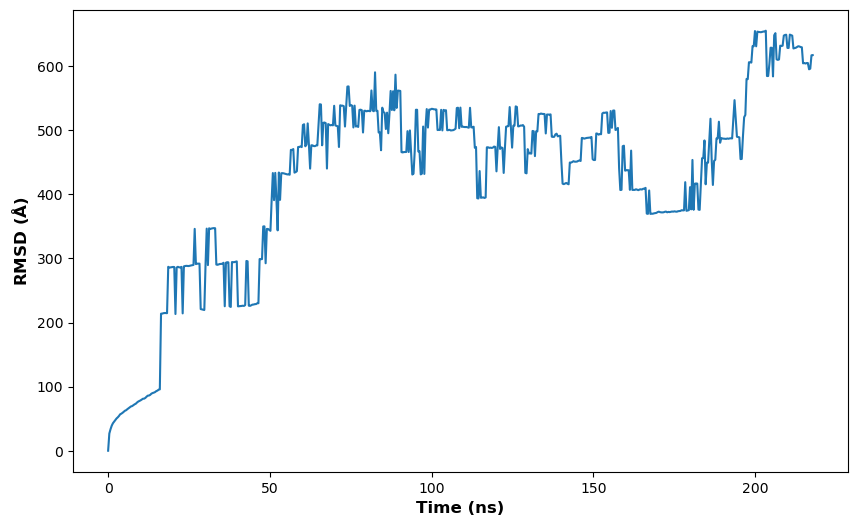

<h2>2. Rg Analysis</h2>

In [69]:
from MDAnalysis.analysis import polymer

protein = u.select_atoms('protein')

frame = []
radgyr = []

for ts in u.trajectory[0:587]:
    rad = protein.radius_of_gyration()
    frame.append(ts.frame)
    radgyr.append(rad)


In [ ]:
print(len(radgyr))

plt.figure(figsize=(10,6))
plt.plot(frame, radgyr, label = 'Rg')
plt.ylabel('Rg ($\\bf{\AA}$)', fontsize = 12, fontweight='bold')
plt.legend()
plt.xlabel('Frame', fontsize = 12, fontweight= 'bold')

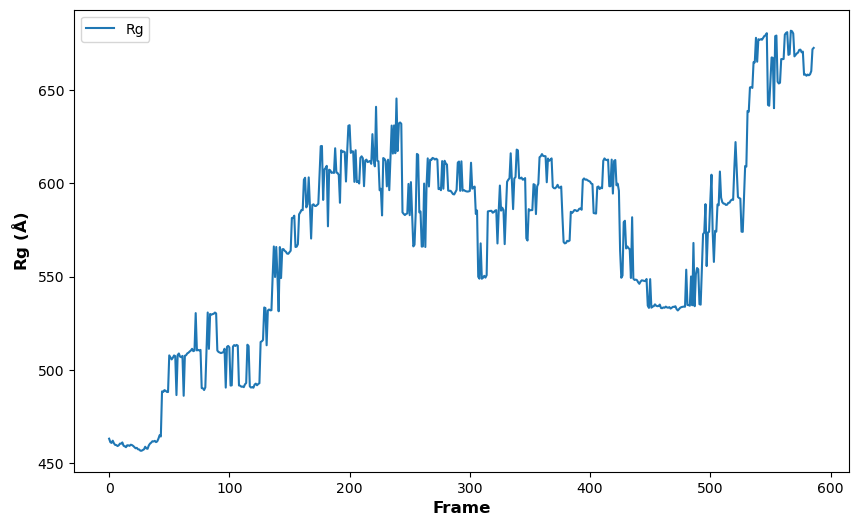

In [ ]:
import os

residue_index_max = int(len(u.residues)/100)

Rg_per_index = []
frames = 'all'

for i in range(0, residue_index_max):
    selection = u.select_atoms(f'resid {i + 1}')
    frame = []
    radgyr = []
    print(i)

    for ts in u.trajectory[1:816]:
        rad = selection.radius_of_gyration()
        frame.append(ts.frame)
        radgyr.append(rad)
    
    Rg_per_index.append(np.array(radgyr).mean())
    os.system('clear')


print(Rg_per_index)

    
    

# selection = u.select_atoms(f'resid {}')



In [41]:
Rg_per_index_nm = [i/10 for i in Rg_per_index]

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(Rg_per_index_nm[1:151], color = 'black')
plt.title(f'Radius of Gyration Rg of individual residues at frames {frames}', fontsize = 15, fontweight = 'bold')
plt.ylabel(' Radius of Gyration $R_{g}$ (${\AA}$)', fontsize = 12, fontweight = 'bold')
plt.xlabel('Amino Acid Residue (1-150)', fontsize = 12, fontweight = 'bold')
plt.axvspan(21, 50, color = 'orange', alpha = 0.1, label='WW1 Domain')
plt.axvspan(80, 113, color = 'red', alpha = 0.1, label='WW2 Domain')
plt.legend()
plt.grid()

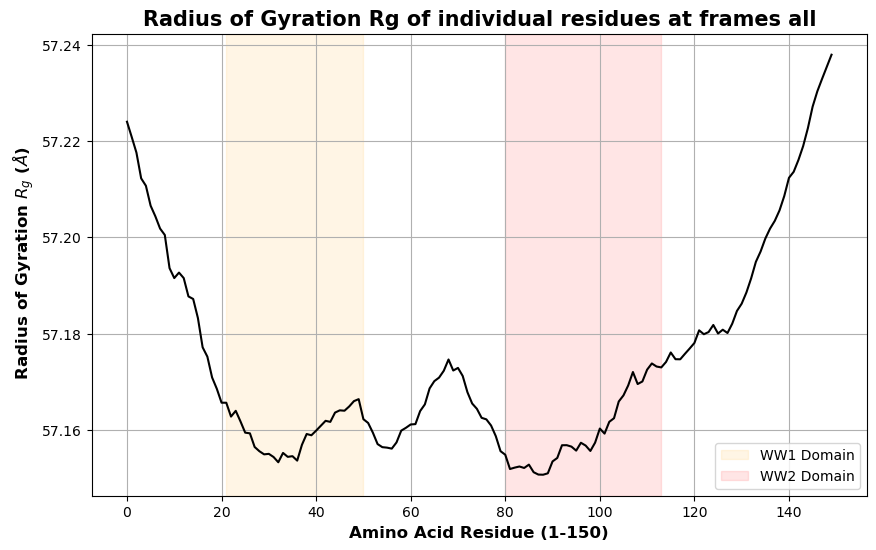

<h2>RMSD and RG plotted on the same graph</h2>

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(timeframe_ns[1:], radgyr, label = 'Rg')

plt.title('$R_g$ vs RMSD graph')
plt.ylabel('RMSD', fontsize = 12, fontweight='bold')
plt.xlabel('$R_g$ ($\\bf{\AA}$)', fontsize = 12, fontweight= 'bold')
plt.grid()
plt.legend()
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot largest cluster size
ax1.set_xlabel('Time (ns)', fontweight = 'bold', fontsize = 12)
ax1.set_ylabel('$\\bf{R_g}$ ($\\bf{\AA}$)', color='black', fontsize = 12, fontweight = 'bold')
ax1.plot(timeframe_ns[1:], radgyr, color='black', markersize = 3)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 1000)

# Create a twin y-axis
ax2 = ax1.twinx()
color2 = 'tab:red'


ax2.set_ylabel('RMSD ($\\bf{\AA}$)', color=color2, fontsize = 12, fontweight='bold')
ax2.plot(timeframe_ns,df['CA'], c = 'red', markersize = 1.5)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, 1000)

# Add grid and title
plt.title('$\\bf R_g$ and RMSD graph plotted against Time', fontweight = 'bold', fontsize = 15)

fig.tight_layout()
plt.grid(True)
plt.show()

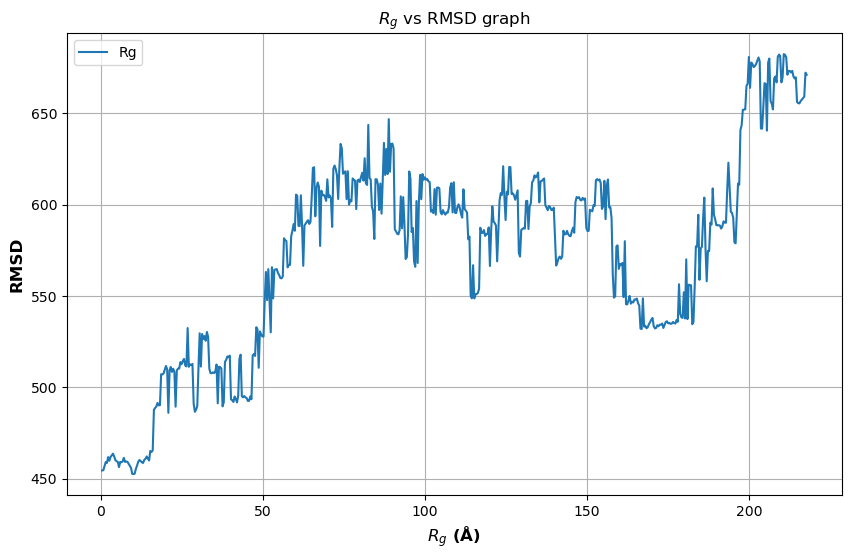

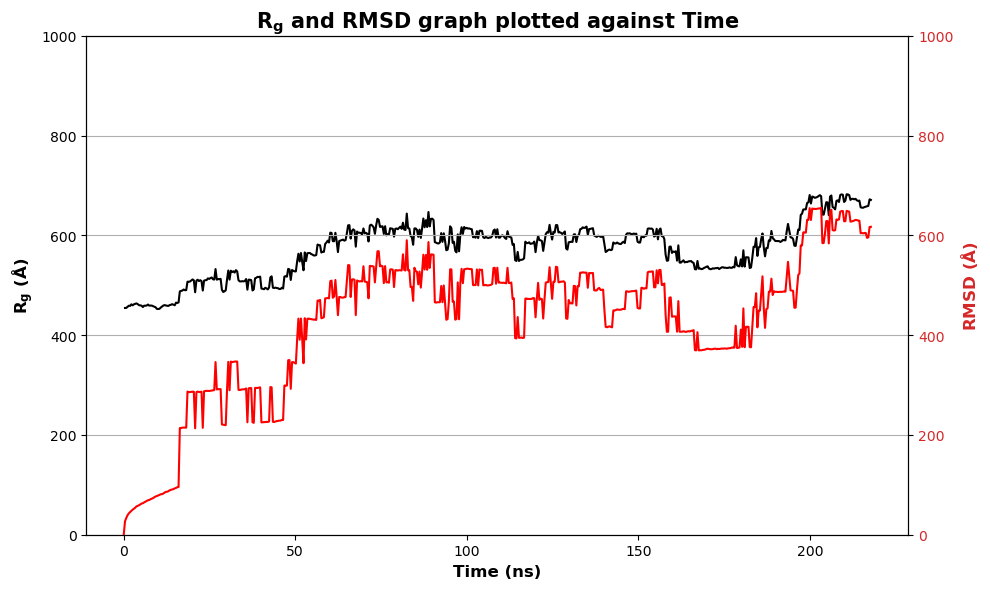

<h2>3. Intermolecular Contact map analysis</h2>

In [ ]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.lib.distances import distance_array
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

Exception ignored in: <function ReaderBase.__del__ at 0x10e9dafc0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mdanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/base.py", line 1531, in __del__
    self.close()
  File "/opt/anaconda3/envs/mdanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/DCD.py", line 181, in close
    self._file.close()
AttributeError: 'DCDReader' object has no attribute '_file'


In [ ]:
residues_per_monomer = 150
contact_threshold = 5.0         # Å
num_monomers = 100
eps_distance = 30               #for DBSCAN clustering
min_samples = 2              #for DBSCAN clustering
num_frames_to_average = 587     #the frames you want to analyze

n_frames = len(u.trajectory)

In [ ]:
def calculate_monomer_com(universe, residues_per_monomer, num_monomers):
    monomer_coords = []
    
    for i in range(num_monomers):
        start_residue = i * (residues_per_monomer + 2)
        end_residue = (i + 1) * (residues_per_monomer + 2)
        coords = universe.residues[start_residue:end_residue].atoms.positions
        monomer_coords.append(coords)

    return np.array([np.mean(coords, axis=0) for coords in monomer_coords])


def cluster_monomers(monomer_com_coords, eps_distance, min_samples):
    dbscan = DBSCAN(eps=eps_distance, min_samples=min_samples)
    labels = dbscan.fit_predict(monomer_com_coords)
    unique_labels = set(labels) - {-1}  # Identify all clusters (exclude noise labeled as -1)
    clusters = {label: np.where(labels == label)[0] for label in unique_labels} # Label each cluster and classify monomers into their clusters
    return clusters

In [ ]:
def get_monomer_coords_by_residue(universe, residues_per_monomer):
    monomer_coords = []

    for i in range(num_monomers):
        start_residue = i * (residues_per_monomer + 2) + 1 #include N-terminus and C-terminus capping
        end_residue = (i + 1) * (residues_per_monomer + 2) - 1
        residues = universe.residues[start_residue: end_residue]
        residue_coords = []
        for residue in residues:
            heavy_atoms = residue.atoms.select_atoms("not name H*")
            coords = heavy_atoms.positions
            residue_coords.append(coords)
        monomer_coords.append(residue_coords)

    return monomer_coords


In [44]:
contact_matrix = np.zeros((residues_per_monomer, residues_per_monomer))
pair_count = 0

# Loop over frames
for ts in u.trajectory[-num_frames_to_average:]:
    monomer_com_coords = calculate_monomer_com(u, residues_per_monomer, num_monomers)
    clusters = cluster_monomers(monomer_com_coords, eps_distance, min_samples)
    monomer_coords = get_monomer_coords_by_residue(u, residues_per_monomer)


    # Go through each cluster one by one
    for indices in clusters.values():
        # Collect coordinates for monomers within this cluster
        cluster_coords = [monomer_coords[i] for i in indices]

        for i in range(len(cluster_coords)):
            for j in range(i + 1, len(cluster_coords)):
                mon_a = cluster_coords[i]
                mon_b = cluster_coords[j]

                temp_contact = np.zeros((residues_per_monomer, residues_per_monomer))

                for idx_a, atoms_a in enumerate(mon_a):
                    for idx_b, atoms_b in enumerate(mon_b):
                        min_dist = np.min(distance_array(atoms_a, atoms_b))

                        if min_dist <= contact_threshold:
                            temp_contact[idx_a, idx_b] += 1
                            if idx_a != idx_b:
                                temp_contact[idx_b, idx_a] += 1

                contact_matrix += temp_contact
                pair_count += 1
print(pair_count)

# Average the contact matrix by intra-cluster pairs
average_contact_matrix = contact_matrix / pair_count
np.savetxt('average_intra_cluster_contact_matrix.csv', average_contact_matrix, delimiter=',')

31873


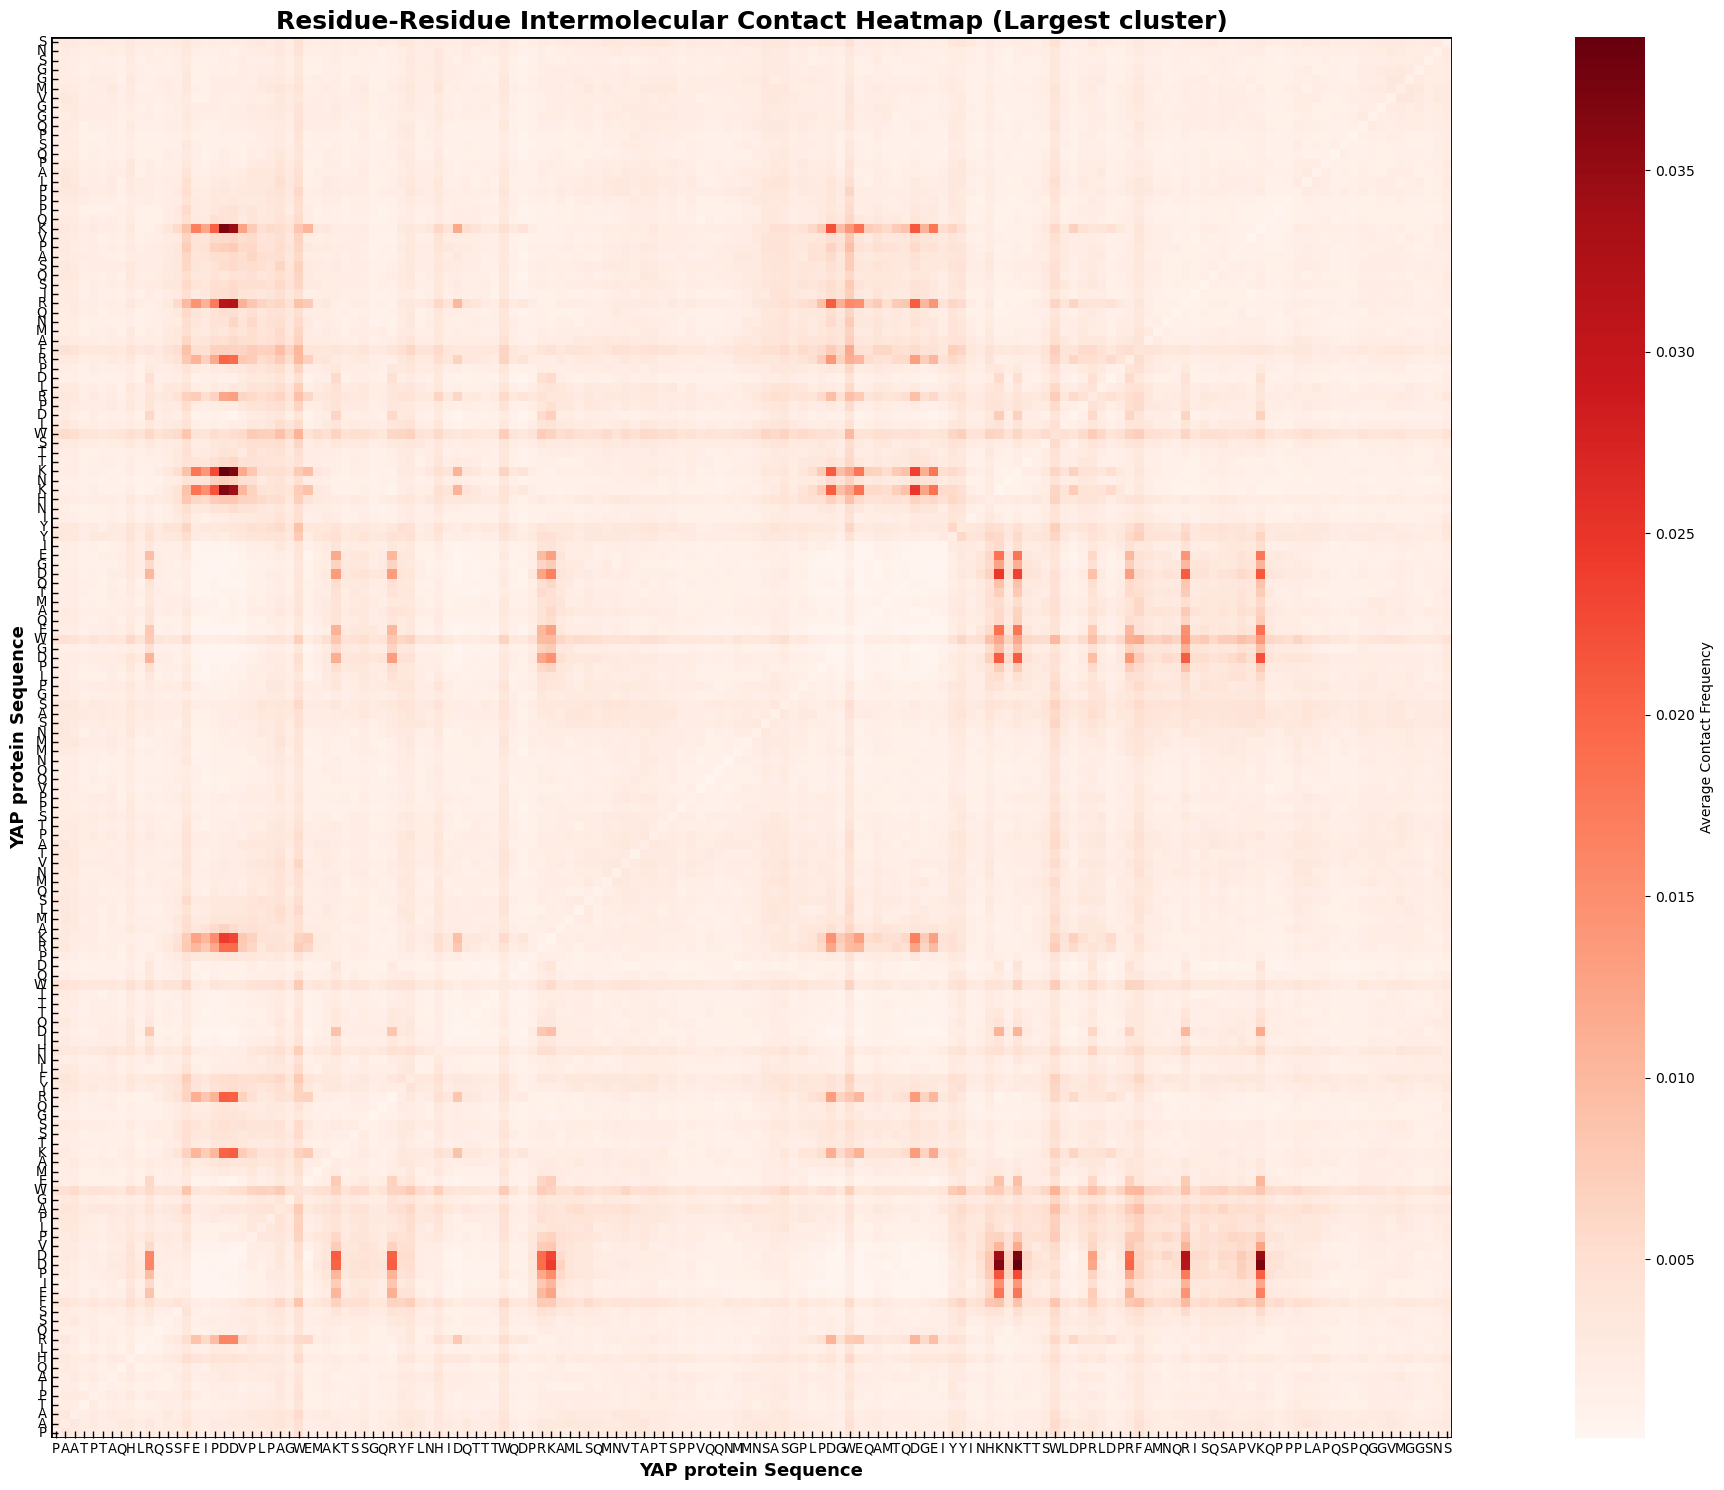

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

# Input your amino acid sequence
amino_acids = list('PAATPTAQHLRQSSFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLSQMNVTAPTSPPVQQNMMNSASGPLPDGWEQAMTQDGEIYYINHKNKTTSWLDPRLDPRFAMNQRISQSAPVKQPPPLAPQSPQGGVMGGSNS')

# Confirm sequence length
assert len(amino_acids) == 150, "Sequence length must be exactly 65 residues."

# Reverse the matrix and y-axis labels for correct visual orientation
matrix_flipped = np.flipud(average_contact_matrix)
amino_acids_reversed = amino_acids[::-1]

plt.figure(figsize=(25, 15))

ax = sns.heatmap(
    matrix_flipped,
    cmap='Reds',
    square=True,
    cbar_kws={'label': 'Average Contact Frequency'},
    xticklabels=amino_acids,
    yticklabels=amino_acids_reversed,
    linewidths=0,
    linecolor='none'
)

# Center the tick labels
plt.xticks(np.arange(len(amino_acids)) + 0.5, amino_acids, fontsize=9.5, rotation=0)
plt.yticks(np.arange(len(amino_acids)) + 0.5, amino_acids_reversed, fontsize=9.5, rotation=0)

# Tick marks inward
ax.tick_params(direction='in', length=5, width=1)

# Add black border around the entire heatmap area
ax.add_patch(Rectangle(
    (0, 0),                     # bottom left corner
    len(amino_acids),          # width
    len(amino_acids),          # height
    fill=False,
    edgecolor='black',
    lw=2,
    zorder=10
))

# Axis labels and title
plt.xlabel('YAP protein Sequence', fontsize=13, fontweight='bold')
plt.ylabel('YAP protein Sequence', fontsize=13, fontweight='bold')
plt.title('Residue-Residue Intermolecular Contact Heatmap (Largest cluster)', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()

<h2>4. How far is distance between terminal and core<h2>

In [ ]:
from MDAnalysis.analysis import distances


distance_per_frame_oi = []
distance_per_frame_io = []
distance_per_frame_termini = []

for i in range(0,587):
    u.trajectory[i]
    ca1 = u.select_atoms('name CA and resid 2')
    ca2 = u.select_atoms(f'name CA and resid 100')
    ca3 = u.select_atoms('name CA and resid 151')
    ca4 = u.select_atoms('name CA and resid 100')
    dist = distances.distance_array(ca1.positions, ca2.positions, box = u.dimensions)
    dist2 = distances.distance_array(ca3.positions, ca4.positions, box = u.dimensions)
    dist3 = distances.distance_array(ca1.positions, ca3.positions, box = u.dimensions)

    dist_for_frame = []
    dist_for_frame2 = []
    dist_for_frame_3 = []


    for item in range(0, 100):
        dist_for_frame.append(dist[item, item])
        dist_for_frame2.append(dist2[item, item])
        dist_for_frame_3.append(dist3[item, item])


    
    distance_per_frame_oi.append(np.mean(dist_for_frame))
    distance_per_frame_io.append(np.mean(dist_for_frame2))
    distance_per_frame_termini.append(np.mean(dist_for_frame_3))



plt.figure(figsize=(10,8))
plt.plot(df['Time (ns)'][2:], distance_per_frame_oi[2:], label = 'N-terminus compared to middle residue')
plt.plot(df['Time (ns)'][2:],distance_per_frame_io[2:], label = 'C-terminus compared to middle residue')
plt.plot(df['Time (ns)'][2:],distance_per_frame_termini[2:], label = 'N-terminus residue compared to C-terminus residue')
plt.title('Comparing Intramolecular distances of residues within a protein throughout the system', fontsize = 15, fontweight='bold')
plt.legend()
plt.xlabel('time (ns)', fontsize = 12, fontweight='bold')
plt.ylabel('Distance between atoms ($\\bf{\AA}$)', fontsize = 12, fontweight='bold')


print(dist2.shape)
print(dist.shape)

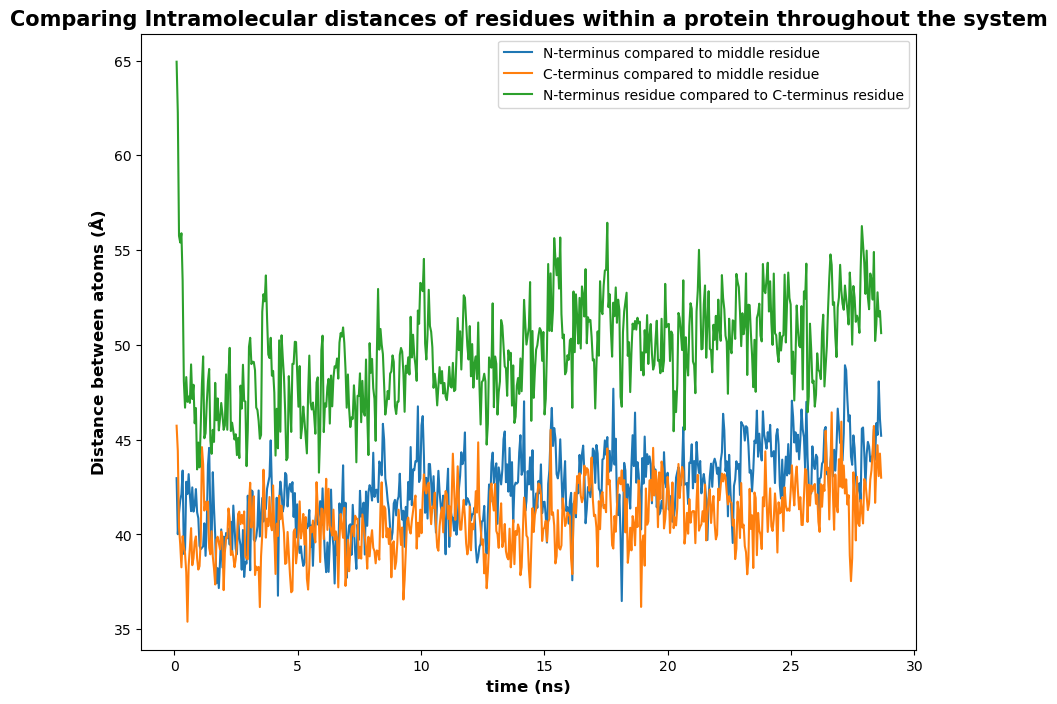

<h2>Analysis of Condensate Formation</h2>


In [50]:
n_proteins = 100
residues_per_protein = 150
total_residues = n_proteins * residues_per_protein


In [51]:

all_residues = u.select_atoms("protein").residues

# Sanity check
assert len(all_residues) == total_residues

# Group into proteins (each 150 residues)
proteins = [all_residues[i:i+residues_per_protein] for i in range(0, total_residues, residues_per_protein)]


In [52]:
def get_protein_COMs(protein_groups):
    return np.array([group.center_of_mass() for group in protein_groups])


In [53]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def sample_COMs(u, protein_groups, stride=100):
    coms_list = []
    for ts in u.trajectory[::stride]:
        coms = get_protein_COMs(protein_groups)
        coms_list.append(coms)
    return coms_list

def plot_kNN_elbow(coms_list, k=2):
    distances_all = []
    for coms in coms_list:
        nbrs = NearestNeighbors(n_neighbors=k).fit(coms)
        distances, _ = nbrs.kneighbors(coms)
        distances_all.extend(np.sort(distances[:, k-1]))

    distances_all = np.sort(distances_all)
    plt.figure(figsize=(10, 6))
    plt.plot(distances_all)
    plt.xlabel("Points (sorted)", fontsize = 12, fontweight= 'bold')
    plt.ylabel(f"{k}-nearest neighbor distance", fontsize = 12, fontweight='bold')
    # plt.ylim(0,40)

    plt.title("Elbow Plot for Choosing `eps`", fontsize = 15, fontweight = 'bold')
    plt.grid(True)
    plt.show()


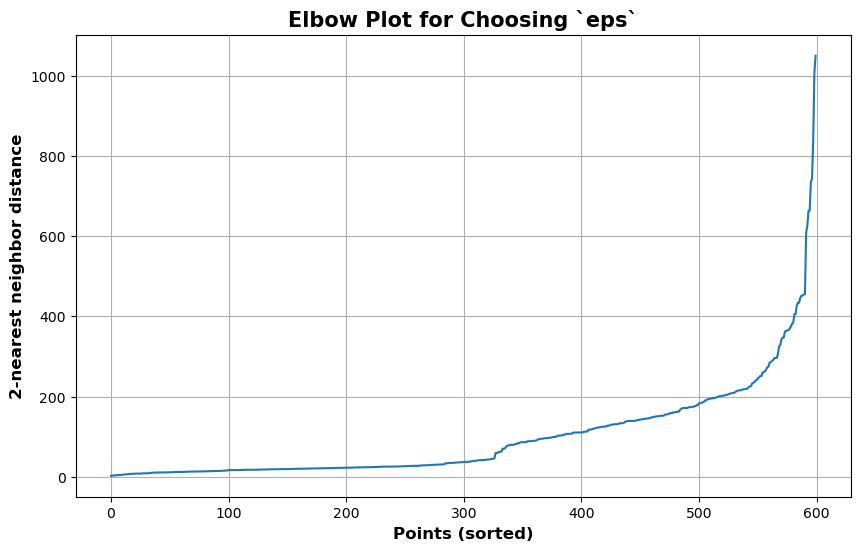

In [54]:
sampled_coms = sample_COMs(u, proteins, stride=100)
plot_kNN_elbow(sampled_coms, k=2)


In [56]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# ---- Settings ----


n_proteins = 100
residues_per_protein = 150
eps = 30.0  # Ångströms, based on elbow plot
min_samples = 2

# ---- Load Universe ----


# ---- Define protein groups ----
all_residues = u.select_atoms("protein").residues
assert len(all_residues) == n_proteins * residues_per_protein

# Group residues into 100 proteins (each 150 residues long)
protein_groups = [all_residues[i:i + residues_per_protein] for i in range(0, len(all_residues), residues_per_protein)]

# ---- Helper to get COMs ----
def get_protein_COMs(groups):
    return np.array([g.center_of_mass() for g in groups])

# ---- Track largest cluster size per frame ----
largest_cluster_sizes = []

for ts in u.trajectory:
    coms = get_protein_COMs(protein_groups)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coms)
    labels = clustering.labels_

    # Exclude noise points (-1)
    valid_labels = labels[labels != -1]

    if len(valid_labels) == 0:
        largest_cluster_sizes.append(0)
    else:
        # Count proteins per cluster
        cluster_sizes = np.bincount(valid_labels)
        largest_cluster_sizes.append(cluster_sizes.max())

In [ ]:
from sklearn.cluster import DBSCAN

eps = 30
cluster_counts = []

for ts in u.trajectory:
    coms = get_protein_COMs(proteins)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coms)
    labels = clustering.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    cluster_counts.append(n_clusters)


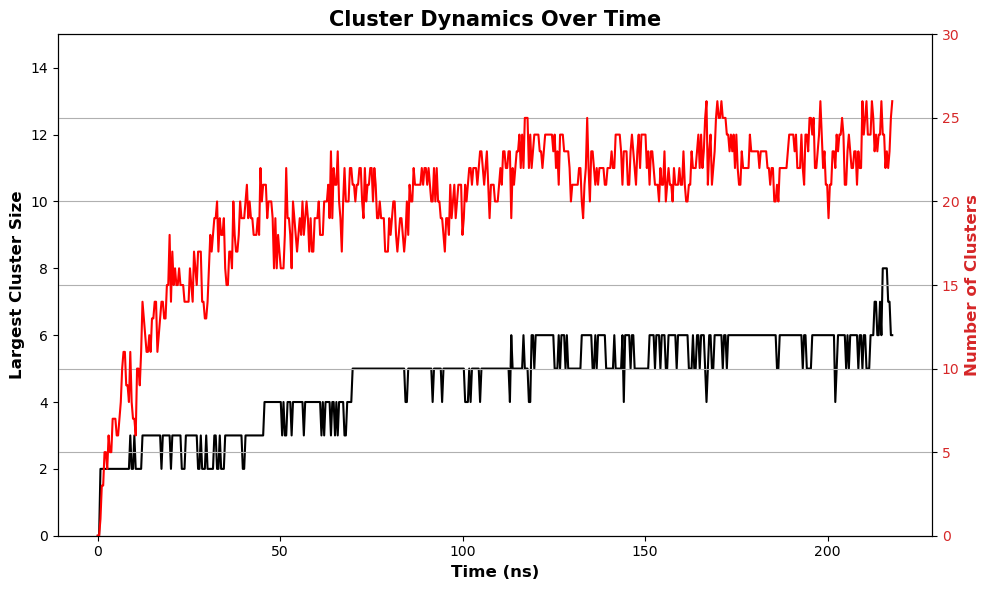

In [57]:
import matplotlib.pyplot as plt

# Assuming you already have these lists from your clustering analysis
# Replace these with your actual data
# largest_cluster_sizes = [...]
# num_clusters = [...]

frames = list(range(len(largest_cluster_sizes)))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot largest cluster size
color1 = 'tab:blue'
ax1.set_xlabel('Time (ns)', fontweight = 'bold', fontsize = 12)
ax1.set_ylabel('Largest Cluster Size', color='black', fontsize = 12, fontweight = 'bold')
ax1.plot(timeframe_ns, largest_cluster_sizes, color='black', label='Largest Cluster Size')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 15)

# Create a twin y-axis
ax2 = ax1.twinx()
color2 = 'tab:red'

ax2.set_ylim(0, 30)
ax2.set_ylabel('Number of Clusters', color=color2, fontsize = 12, fontweight='bold')
ax2.plot(timeframe_ns,cluster_counts, c = 'red')
ax2.tick_params(axis='y', labelcolor=color2)

# Add grid and title
plt.title('Cluster Dynamics Over Time', fontweight = 'bold', fontsize = 15)
fig.tight_layout()
plt.grid(True)
plt.show()


<h2>6.DSSP secondary structure analysis</h2>

In [ ]:
from tqdm import tqdm
import MDAnalysis as mda
from sklearn.cluster import DBSCAN
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from collections import Counter

# ---- Load universe and select protein ----
 # Replace with your actual file names
protein = u.select_atoms("protein")

n_proteins = 100
residues_per_protein = 150
eps = 30.0
min_samples = 2

# Group residues into per-protein groups
protein_groups = [
    protein.residues[i:i + residues_per_protein]
    for i in range(0, len(protein.residues), residues_per_protein)
]

def get_protein_COMs(groups):
    return np.array([g.center_of_mass() for g in groups])

# ---- Set up structure counters ----
position_structures_condensed = [Counter() for _ in range(residues_per_protein)]
position_counts_condensed = np.zeros(residues_per_protein)

position_structures_dilute = [Counter() for _ in range(residues_per_protein)]
position_counts_dilute = np.zeros(residues_per_protein)

residue_names = ["UNK"] * residues_per_protein

helix_codes = {'H', 'G', 'I'}
beta_codes = {'E', 'B'}
intra_codes = {'B'}
extra_codes = {'E'}

# ---- Process trajectory ----
for ts in tqdm(u.trajectory, desc="Processing frames"):
    coms = get_protein_COMs(protein_groups)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coms)
    labels = clustering.labels_

    valid_labels = labels[labels != -1]
    if len(valid_labels) == 0:
        continue

    largest_label = np.bincount(valid_labels).argmax()
    clustered_indices = [i for i, label in enumerate(labels) if label == largest_label]
    dilute_indices = [i for i, label in enumerate(labels) if label == -1]

    for is_condensed, indices in [(True, clustered_indices), (False, dilute_indices)]:
        for i in indices:
            protein_residues = protein_groups[i]
            atoms = protein_residues.atoms
            sub_u = mda.Merge(atoms)
            sub_u.atoms.positions = atoms.positions.copy()
            sub_u.atoms.write("temp_protein.pdb")

            traj = md.load("temp_protein.pdb")
            ss = md.compute_dssp(traj, simplified=False)[0]

            for j, (res, sstruct) in enumerate(zip(traj.topology.residues, ss)):
                if j >= residues_per_protein:
                    continue

                if is_condensed:
                    position_structures_condensed[j][sstruct] += 1
                    position_counts_condensed[j] += 1
                else:
                    position_structures_dilute[j][sstruct] += 1
                    position_counts_dilute[j] += 1

                residue_names[j] = res.name

# ---- Compute probability distributions for condensed peptides ----
fraction_with_beta = []
fraction_with_bridge = []
fraction_with_sheet = []

for ts in tqdm(u.trajectory, desc="Re-scanning condensed phase"):
    coms = get_protein_COMs(protein_groups)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coms)
    labels = clustering.labels_

    valid_labels = labels[labels != -1]
    if len(valid_labels) == 0:
        continue

    largest_label = np.bincount(valid_labels).argmax()
    clustered_indices = [i for i, label in enumerate(labels) if label == largest_label]
    if not clustered_indices:
        continue

    has_beta, has_bridge, has_sheet = [], [], []

    for i in clustered_indices:
        protein_residues = protein_groups[i]
        atoms = protein_residues.atoms
        sub_u = mda.Merge(atoms)
        sub_u.atoms.positions = atoms.positions.copy()
        sub_u.atoms.write("temp_protein.pdb")

        traj = md.load("temp_protein.pdb")
        ss = md.compute_dssp(traj, simplified=False)[0]

        has_b = any(s in beta_codes for s in ss)
        has_bbridge = 'B' in ss
        has_bsheet = 'E' in ss

        has_beta.append(has_b)
        has_bridge.append(has_bbridge)
        has_sheet.append(has_bsheet)

    n = len(clustered_indices)
    if n > 0:
        fraction_with_beta.append(sum(has_beta) / n)
        fraction_with_bridge.append(sum(has_bridge) / n)
        fraction_with_sheet.append(sum(has_sheet) / n)

# ---- Compute helix and beta frequencies ----
helix_freq_condensed, beta_freq_condensed, intra_condens, extra_condens = [], [], [], []
helix_freq_dilute, beta_freq_dilute, extra_dil  = [], [], []

x_labels = []

for i in range(residues_per_protein):
    # Condensed
    total_c = position_counts_condensed[i]
    counts_c = position_structures_condensed[i]
    helix_c = sum(counts_c[c] for c in helix_codes)
    beta_c = sum(counts_c[c] for c in beta_codes)
    intra_c = sum(counts_c[c] for c in intra_codes)
    extra_c = sum(counts_c[c] for c in extra_codes)
    helix_freq_condensed.append(helix_c / total_c if total_c > 0 else 0)
    beta_freq_condensed.append(beta_c / total_c if total_c > 0 else 0)
    intra_condens.append(intra_c / total_c if total_c > 0 else 0)
    extra_condens.append(extra_c / total_c if total_c > 0 else 0)

    # Dilute
    total_d = position_counts_dilute[i]
    counts_d = position_structures_dilute[i]
    helix_d = sum(counts_d[c] for c in helix_codes)
    beta_d = sum(counts_d[c] for c in beta_codes)
    extra_d = sum(counts_d[c] for c in extra_codes)
    helix_freq_dilute.append(helix_d / total_d if total_d > 0 else 0)
    beta_freq_dilute.append(beta_d / total_d if total_d > 0 else 0)
    extra_dil.append(extra_d /total_d if total_d > 0 else 0)

    x_labels.append(f"{i+1}-{residue_names[i]}")



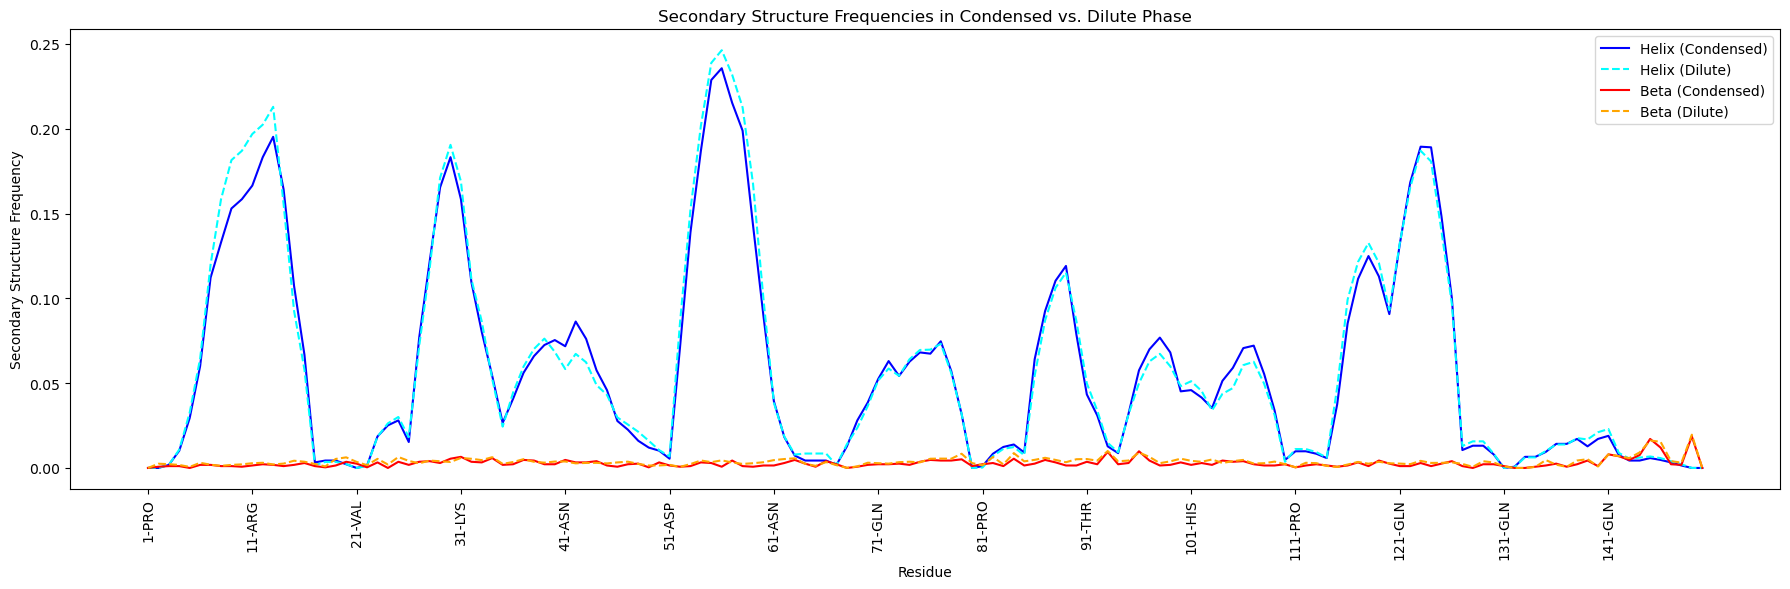

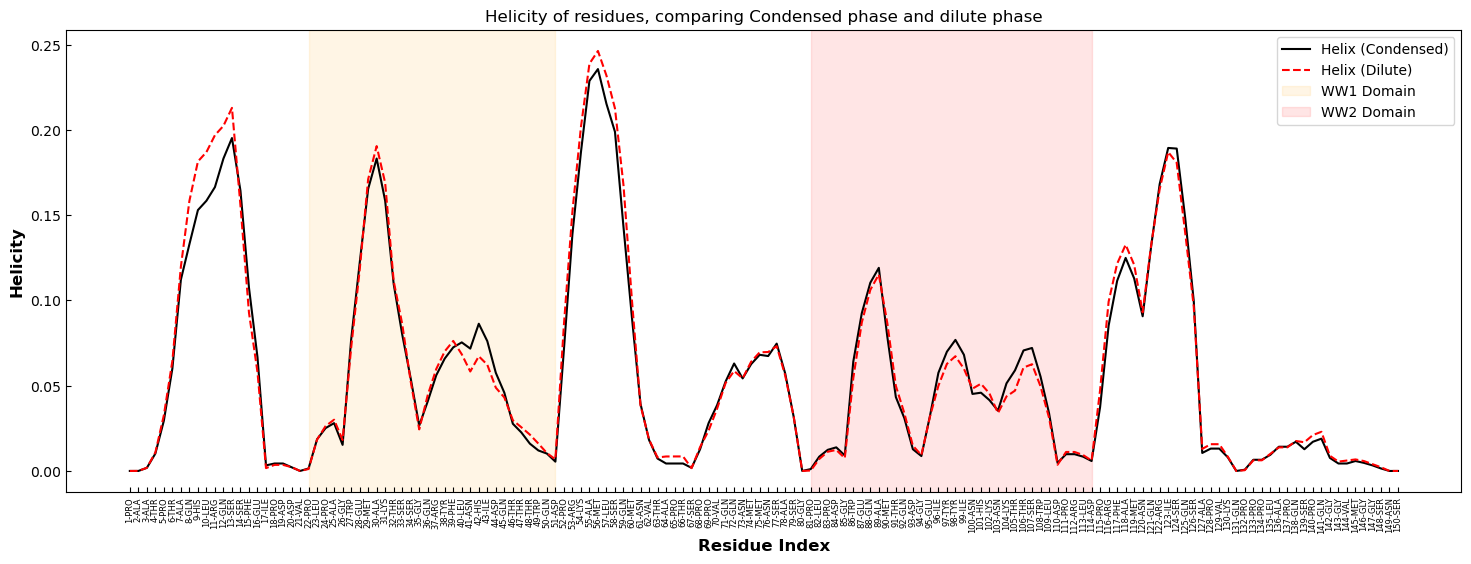

In [ ]:
plt.figure(figsize=(18, 6))

plt.plot(x_labels, helix_freq_condensed, label="Helix (Condensed)", color='black')
plt.plot(x_labels, helix_freq_dilute, label="Helix (Dilute)", color='red', linestyle='--')
plt.ylabel('Helicity', fontsize = 12, fontweight = 'bold')
plt.xlabel('Residue Index', fontsize = 12, fontweight = 'bold')
plt.title('Helicity of residues, comparing Condensed phase and dilute phase')
# plt.axvspan(21, 50, color = 'orange', alpha = 0.1, label='WW1 Domain') #CHANGE or disable if oyu want to highlight any regions
# plt.axvspan(80, 113, color = 'red', alpha = 0.1, label='WW2 Domain')   #CHANGE or disable if oyu want to highlight any regions
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.show()

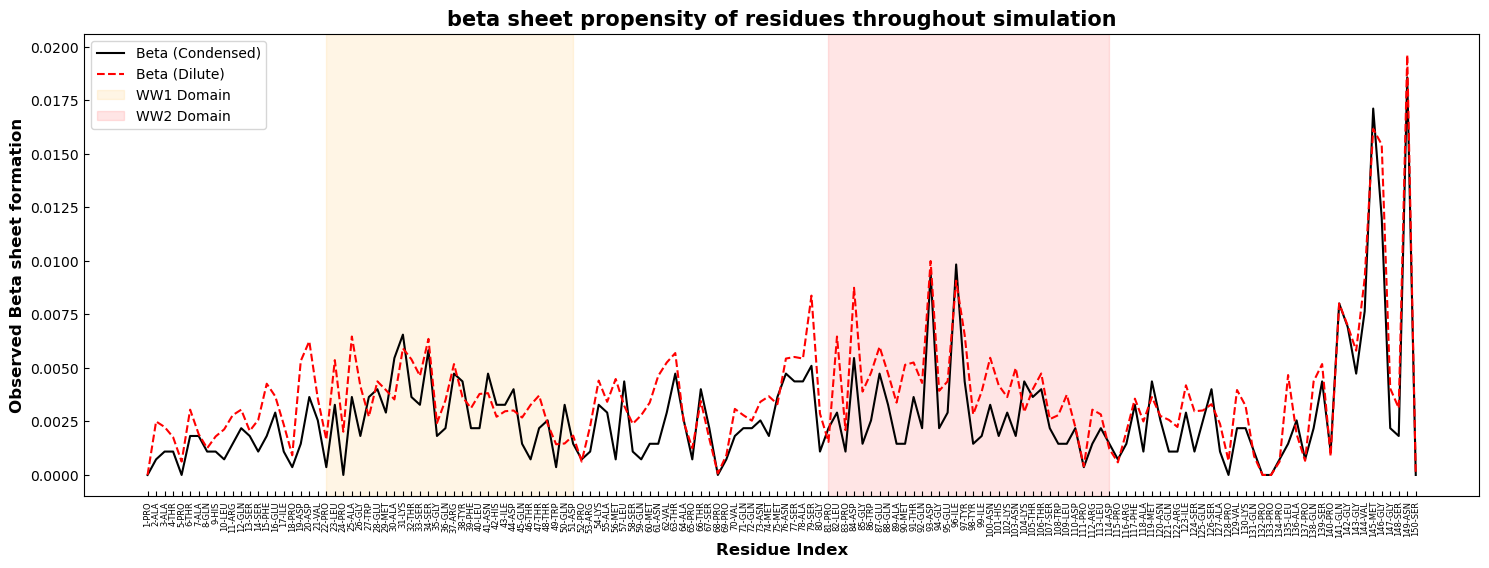

In [ ]:
plt.figure(figsize=(18, 6))


plt.plot(x_labels, beta_freq_condensed, label="Beta (Condensed)", color='black')
plt.plot(x_labels, beta_freq_dilute, label="Beta (Dilute)", color='red', linestyle='--')
plt.xlabel('Residue Index', fontsize = 12, fontweight = 'bold')
plt.ylabel('Observed Beta sheet formation', fontsize = 12, fontweight = 'bold')
plt.title('beta sheet propensity of residues throughout simulation', fontsize = 15, fontweight ='bold')
# plt.axvspan(21, 50, color = 'orange', alpha = 0.1, label='WW1 Domain')
# plt.axvspan(80, 113, color = 'red', alpha = 0.1, label='WW2 Domain')
plt.xticks(rotation=90, fontsize=6)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.legend()
plt.show()


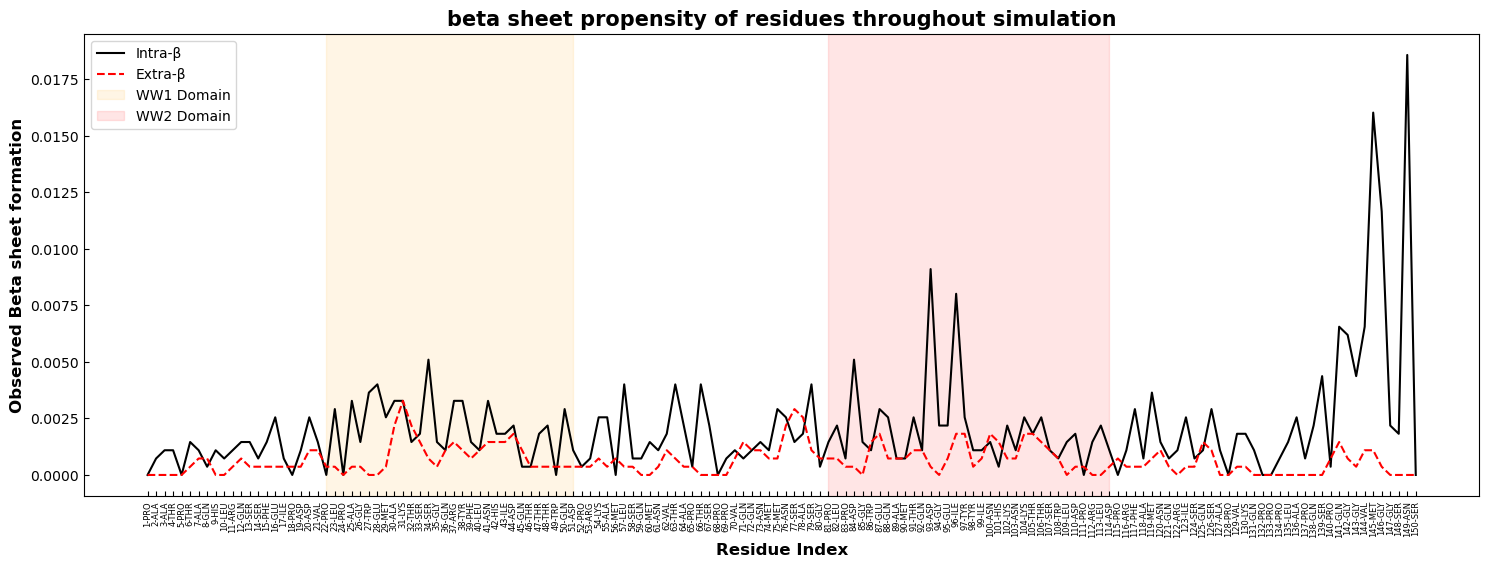

In [ ]:
plt.figure(figsize=(18, 6))


plt.plot(x_labels, intra_condens, label="Intra-β", color='black')
plt.plot(x_labels, extra_condens, label="Extra-β", color='red', linestyle='--')
plt.xlabel('Residue Index', fontsize = 12, fontweight = 'bold')
plt.ylabel('Observed Beta sheet formation', fontsize = 12, fontweight = 'bold')
plt.title('beta sheet propensity of residues throughout simulation', fontsize = 15, fontweight ='bold')
# plt.axvspan(21, 50, color = 'orange', alpha = 0.1, label='WW1 Domain')
# plt.axvspan(80, 113, color = 'red', alpha = 0.1, label='WW2 Domain')
plt.xticks(rotation=90, fontsize=6)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.legend()
plt.show()


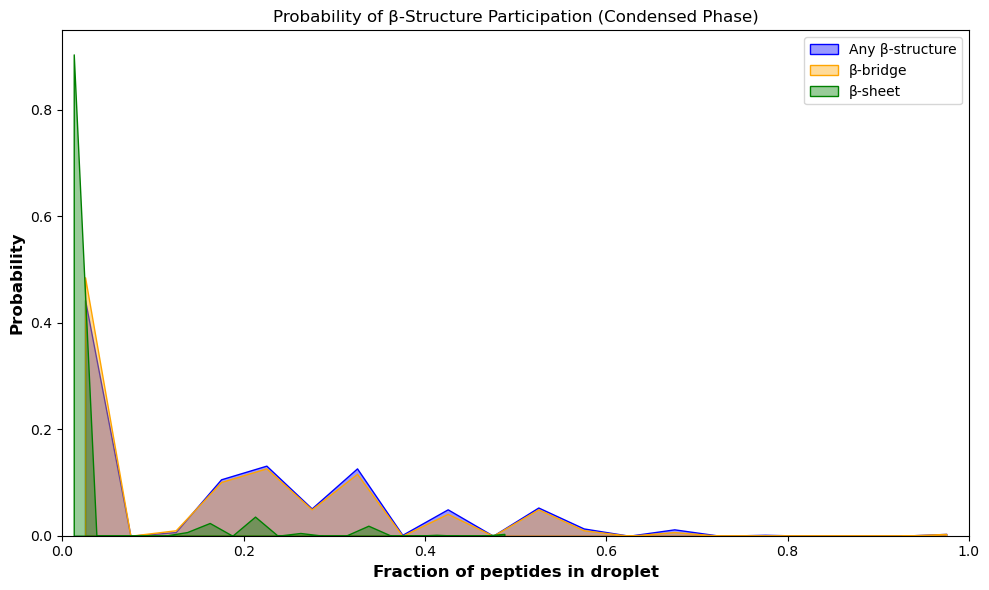

In [80]:
plt.figure(figsize=(10, 6))

sns.histplot(fraction_with_beta, label="Any β-structure", color='blue', 
             stat="probability", kde=False, bins=20, element="poly", fill=True, alpha=0.4)

sns.histplot(fraction_with_bridge, label="β-bridge", color='orange', 
             stat="probability", kde=False, bins=20, element="poly", fill=True, alpha=0.4)

sns.histplot(fraction_with_sheet, label="β-sheet", color='green', 
             stat="probability", kde=False, bins=20, element="poly", fill=True, alpha=0.4)

plt.xlabel("Fraction of peptides in droplet", fontsize = 12, fontweight = 'bold')
plt.ylabel("Probability", fontsize = 12, fontweight = 'bold')
plt.xlim(0, 1)
plt.title("Probability of β-Structure Participation (Condensed Phase)")
plt.legend()
plt.tight_layout()
plt.show()
